# **M4 Iris Data Set**





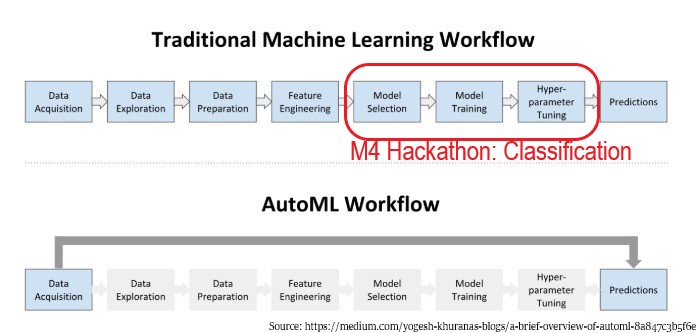



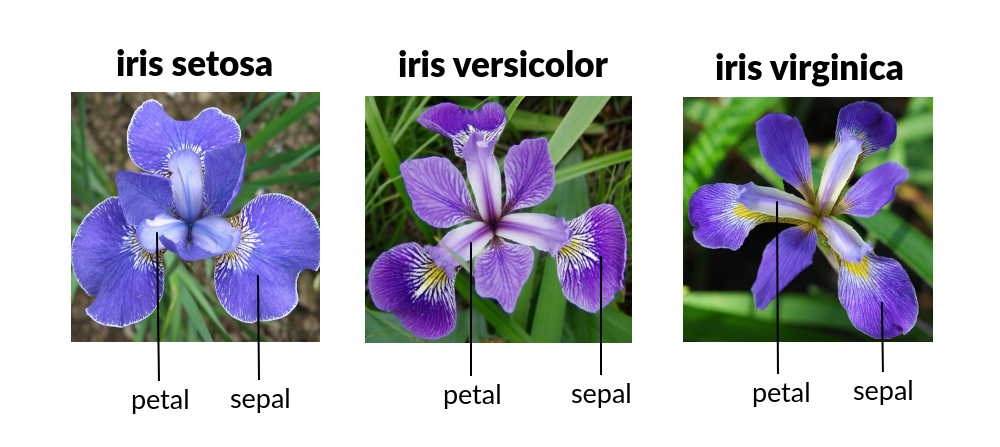
Source: https://medium.com/@naidubhavya06/detailed-explanation-of-exploratory-data-analysis-using-iris-dataset-fa8082a4ce0f Fair use claimed.

#**Table of Contents**
* Business Problem & Metrics
* Executive SUmmary (BLUF)
* Libraries & Supplementary Code
* Data
* Holdout Sample
* Scaling
* Decision Regions of Unbalanced Data
* Aggregate Performance Measures Using Unbalanced Data
* Interim Leaderboard
* Aggregate Performance Measures Using Balanced Data (After SMOTE)
* Leaderboard after SMOTE
* Grid Search
* Learning Curves
* Propensities
* Conclusion




#**Business Problem & Metrics**

##Business Problem##
To identify *itris virginica* in a commercial flower sorting and shipping facility in Virginia. The facility receives mixed deliveries of recently harvested *iris virginica*, *irtis setosa* and *iris versicolor* from local growers in roughly equal quantities of each species. It sorts the flowers by species and ships to florists nationwide on demand. All three species are of roughly equal commercial value per stem. An automated camera-and-ML solution is sought for the start of the sorting line. *Iris setosa* and *iris versicolor* are sorted at a subsequent point in the line. 

##*BREAKING NEWS: due to calibration issues, the camera can only measure sepal width and petal width at the current time.*##

##Metrics##
The challenge is to ensure homogenity in the shipments of each species of itris. Therefore both AUC and accuracy metrics will be employed. AUC will be used as the primary metric as it measures how well a classifier separates the target variable categories. Accuracy is also an important measures as it provides an indication of the overall level of misclassification error in the shipments (false positives and false negatives are of about equal importance, as FNs may wind up in shipments of either *iris setosa* or *iris versicolor*).


#**Executive Summary (BLUF)**
Deploy a support vector machine (SVM) to classify *iris virginica*, with optimized parameters (gamma = .01, rbf kernel, and C=1) using predictors 'sepal_width' and 'petal_width' to realize an expected AUC of 0.99 and expected accuracy of 0.949. Decision region analysis on the unbalanced suggests that the SVM and LightGBM classifiers may offer the best fits. 

In the iris shipping case, the SVM solution likely suffices for automated detection and harvesting of *iris virginica* in a field of irises.




#**Libraries & Supplementary Code**

In [ ]:
# Basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

In [ ]:
# XGBoost
from xgboost import XGBClassifier

In [ ]:
# LightGBM
#!pip install lightgbm
from lightgbm import LGBMClassifier

In [ ]:
# imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

In [ ]:
# The code below comes from p. 32 of the class text by Raschka & Mirjlili
# It plots the decision regions of a classifier with two predictors

from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max()), plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
        
def decision_region(classifier_, X, y, title, x_ax, y_ax):
  plot_decision_regions(X, y, classifier=classifier_)
  plt.title(title)
  plt.xlabel(x_ax)
  plt.ylabel(y_ax)
  plt.legend(loc='upper left')
  plt.tight_layout()
  plt.show()

#**Data**

For simplicity, we'll work with the iris data set out of the box, with the exception of dummy-encioding the target variable ('Species')

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Read 
file_ = "drive/My Drive/Colab Notebooks/Big Data ML/New BDML/Data/iris.csv"   # adapt this as needed to the file structure on your Google drive
df = pd.read_csv(file_) # read in csv file

Mounted at /content/drive


In [ ]:
# Dummy-encode the target variable
df = pd.get_dummies(data=df, columns=['species'],drop_first=True)

# Examine the data using df.head()
print("HEAD of df\n", df.head(20))

# Shape of DataFrame
print("\nSHAPE of df\n", df.shape) 

HEAD of df
     sepal_length  sepal_width  petal_length  petal_width  species_versicolor  \
0            5.1          3.5           1.4          0.2                   0   
1            4.9          3.0           1.4          0.2                   0   
2            4.7          3.2           1.3          0.2                   0   
3            4.6          3.1           1.5          0.2                   0   
4            5.0          3.6           1.4          0.2                   0   
5            5.4          3.9           1.7          0.4                   0   
6            4.6          3.4           1.4          0.3                   0   
7            5.0          3.4           1.5          0.2                   0   
8            4.4          2.9           1.4          0.2                   0   
9            4.9          3.1           1.5          0.1                   0   
10           5.4          3.7           1.5          0.2                   0   
11           4.8          3.

In [ ]:
# Save df to Google drive as csv file (to submit to DRiverless AI)
# Uncomment the next two lines if you want to execute this code
#df = df[['sepal_width','petal_width','species_virginica']]
#df.to_csv("/content/drive/My Drive/Colab Notebooks/Big Data ML/New BDML/Data/iris_2pred_virginica.csv", index=False)

#**Holdout Sample**

Source: https://www.researchgate.net/publication/334119803_Secure_Learning_para_deteccion_de_Android_Malware/figures?lo=1
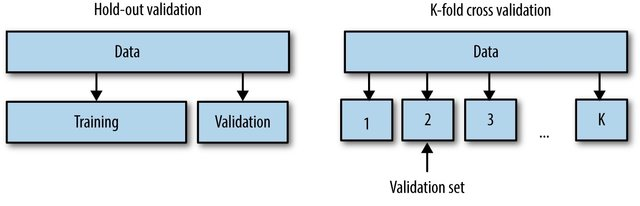

In [ ]:
# Split data into predictors X and target y
# Treating virginica as target (virginica is the 'positive' category abd setosa and versicolor are in the 'negative' category)
# Using just two predictors ('sepal width' and 'petal width') so that we can examine the decision regions of the classifiers
X = df[['sepal_width','petal_width']]
y = df['species_virginica']

In [ ]:
# Create holdout sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('Training Data Predictors\n',X_train.head(), '\nTraining Data Target\n',y_train.head(),'\n')
print('Test Data Predictors\n',X_test.head(), '\nTest Data Target\n',y_test.head())


Training Data Predictors
      sepal_width  petal_width
81           2.4          1.0
133          2.8          1.5
137          3.1          1.8
75           3.0          1.4
109          3.6          2.5 
Training Data Target
 81     0
133    1
137    1
75     0
109    1
Name: species_virginica, dtype: uint8 

Test Data Predictors
      sepal_width  petal_width
73           2.8          1.2
18           3.8          0.3
118          2.6          2.3
78           2.9          1.5
76           2.8          1.4 
Test Data Target
 73     0
18     0
118    1
78     0
76     0
Name: species_virginica, dtype: uint8


#**Scaling**
* Standardizing involves the transformation of data into z-scores (by subtracting the feature mean and divding by the feature standard deviation). It's purpose is to ensure all features are on a common scale without distorting the relative differences between the instance values. Use standardizaition when there is no natural upper or lower bound for the feature in the use case.
* Normalization involves conversion of feature values to an interval (typically [0,1]). Use normalization when a feature has an upper and lower bound in the use case.


In [ ]:
# Standardization of predictor
stdsc = StandardScaler()  
X_train_std = stdsc.fit_transform(X_train)   
X_test_std = stdsc.transform(X_test)             # transform uses the parameters from scaling the training data to transform our test data
print('Mean and Standard Deviation of sepal_width in Training Data: ',X_train_std[:,0].mean(), '  ',X_train_std[:,0].std())
print('Mean and Standard Deviation of sepal width in Test Data: ',X_test_std[:,0].mean(), '  ',X_test_std[:,0].std())

Mean and Standard Deviation of sepal_width in Training Data:  4.906789260620112e-18    0.9999999999999999
Mean and Standard Deviation of sepal width in Test Data:  0.39742548724365107    1.0982256141107127


#**Decision Regions of Unbalanced Data**

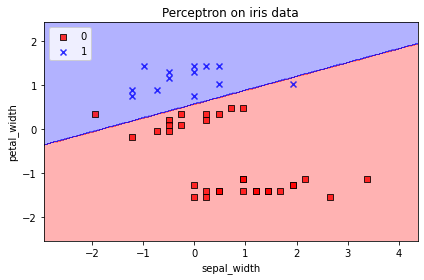

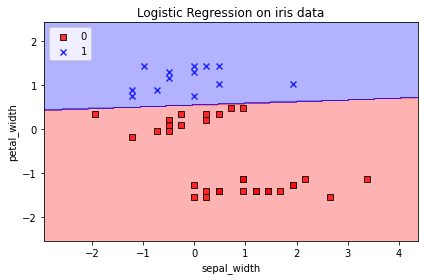

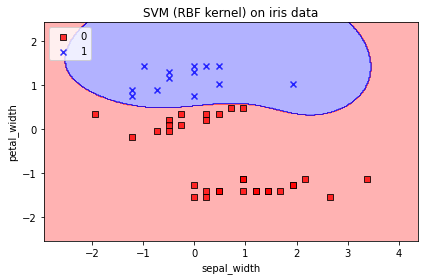

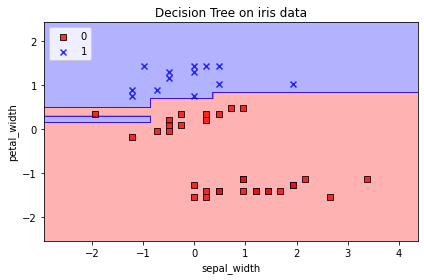

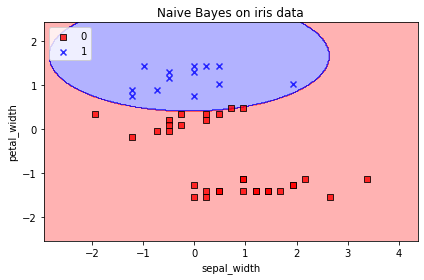

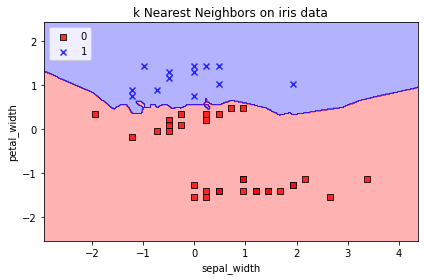

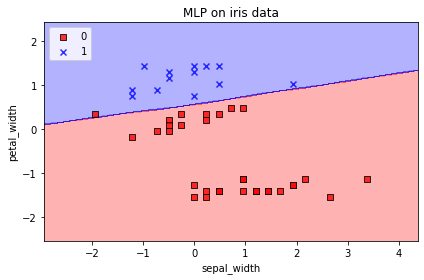

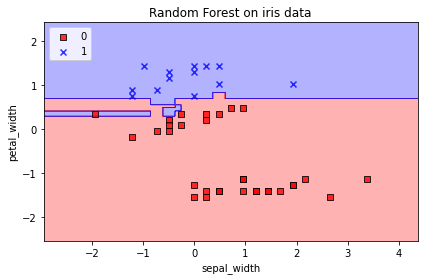

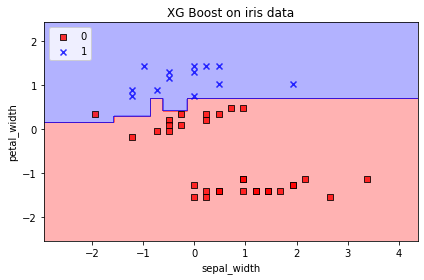

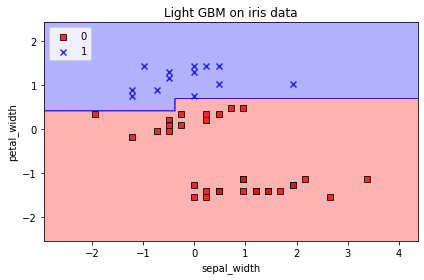

In [ ]:
# Classifier decision regions on unbalanced holdout sample
names = ["Perceptron", "Logistic Regression", "SVM (RBF kernel)", "Decision Tree", "Naive Bayes", "k Nearest Neighbors", "MLP", "Random Forest", "XG Boost", "Light GBM"]

classifiers = [
    Perceptron(random_state=1),    
    LogisticRegression(),   
    SVC(kernel="rbf", C=1),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB(),
    KNeighborsClassifier(3),
    MLPClassifier(hidden_layer_sizes=(50,50),alpha=1, max_iter=1000),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=3),
    LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50, learning_rate=0.1, bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)]

# Build each classifier using the unbalanced TRAINING data, show decision region and petrformance of the unbalanced TEST data 
for name, clf in zip(names, classifiers):
  clf.fit(X_train_std, y_train)
  decision_region(clf, X_test_std, y_test, name + ' on iris data','sepal_width','petal_width')


#**Aggregate Performance Measures - Unbalanced Data**
Some measures are not a fair reflection of performance when te dataset is unbalanced.

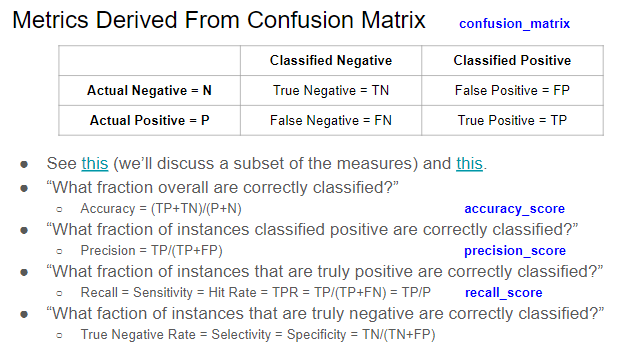

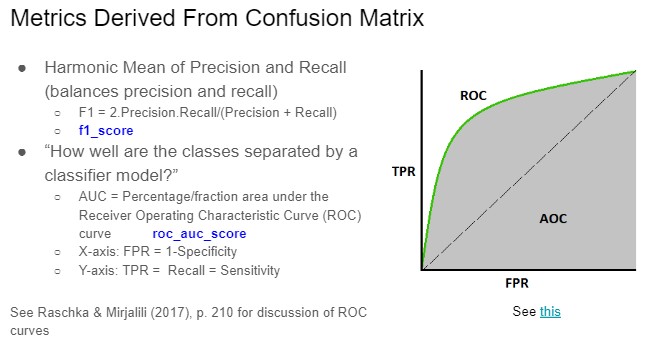

In [ ]:
# Performance Measures - Unbalanced Data, Cross Validation, with a Pipeline
names = ["Perceptron", "Logistic Regression", "SVM (RBF kernel)", "Decision Tree", "Naive Bayes", "k Nearest Neighbors", "MLP", "Random Forest", "XG Boost", "Light GBM"]

classifiers = [
    Perceptron(random_state=1),    
    LogisticRegression(),   
    SVC(kernel="rbf", C=1),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB(),
    KNeighborsClassifier(3),
    MLPClassifier(hidden_layer_sizes=(50,50),alpha=1, max_iter=1000),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=3),
    LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50, learning_rate=0.1, bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)]

# Build each classifier using the unbalanced TRAINING data, show decision region and petrformance of the unbalanced TEST data 
for name, clf in zip(names, classifiers):
  # Pipeline
  estimators = []
  estimators.append(('standardize', StandardScaler()))
  estimators.append(('classifier',clf))
  model = Pipeline(estimators)
  # Eval Pipeline
  kfold_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=11)
  scoring = ['accuracy','balanced_accuracy','precision','recall','f1','roc_auc']
  for sc in scoring:
    results = cross_val_score(model, X=X, y=y, cv=kfold_cv, scoring=sc)
    print('Classifier: %s Metric %s mean (std deviation): %.3f (%.3f)' % (name, sc, results.mean(), results.std()))
 

Classifier: Perceptron Metric accuracy mean (std deviation): 0.947 (0.034)
Classifier: Perceptron Metric balanced_accuracy mean (std deviation): 0.954 (0.025)
Classifier: Perceptron Metric precision mean (std deviation): 0.885 (0.079)
Classifier: Perceptron Metric recall mean (std deviation): 0.979 (0.029)
Classifier: Perceptron Metric f1 mean (std deviation): 0.927 (0.041)
Classifier: Perceptron Metric roc_auc mean (std deviation): 0.990 (0.012)
Classifier: Logistic Regression Metric accuracy mean (std deviation): 0.960 (0.016)
Classifier: Logistic Regression Metric balanced_accuracy mean (std deviation): 0.950 (0.030)
Classifier: Logistic Regression Metric precision mean (std deviation): 0.961 (0.028)
Classifier: Logistic Regression Metric recall mean (std deviation): 0.920 (0.073)
Classifier: Logistic Regression Metric f1 mean (std deviation): 0.937 (0.028)
Classifier: Logistic Regression Metric roc_auc mean (std deviation): 0.992 (0.010)
Classifier: SVM (RBF kernel) Metric accuracy

#**Interim Leaderboard**

Classifier performance results are as follows (results may vary due to random seed). Ordered by AUC.

|**Classifier** |    Accuracy    |       Balanced Accuracy      |    AUC    |
|:----------------------|:------------:|:--------------:|:-------------:|
|Perceptron | 0.947 | 0.955 |0.993 |
|Multilayer Perceptron | 0.933 | 0.936 | 0.992 |
|Logistic Regression | 0.940 | 0.936 |0.990 |
|Support Vector Machine | 0.947 | 0.941 | 0.990 |
|Naive Bayes | 0.920 | 0.920 | 0.982 |
|LightGBM | 0.953 |  0.946 | 0.982 |
|XGBoost | 0.953 | 0.946 | 0.971 |
|kNN | 0.953 | 0.946 | 0.969 |
|Random Forest (RF) | 0.927 | 0.915 | 0.964 | 
|Decision Tree | 0.933 | 0.920 | 0.919 |

The dataset is tiny, and the Perceptron scores an unusual victory (on balanced accuracy and AUC measures) here, maybe as a result of that.

#**Aggregate Performance Measures Using Balanced Data (After SMOTE)**



In [ ]:
# Workflow standardizes, SMOTEs training set, fits a classifier, and reports metrics.
# SMOTE evidently doesn't have a 'fit_transform' method, so there's no way to incorporate it into an sklearn pipeline
# We'll consider an alternative - an imblearn pipeline in the gridsearch section

names = ["Perceptron", "Logistic Regression", "SVM (RBF kernel)", "Decision Tree", "Naive Bayes", "k Nearest Neighbors", "MLP", "Random Forest", "XG Boost", "Light GBM"]
classifiers = [
    Perceptron(random_state=1),    
    LogisticRegression(),   
    SVC(kernel="rbf", C=1),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB(),
    KNeighborsClassifier(3),
    MLPClassifier(hidden_layer_sizes=(50,50),alpha=1, max_iter=1000),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=3),
    LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50, learning_rate=0.1, bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)]

# Build each classifier using the unbalanced TRAINING data, show decision region and petrformance of the unbalanced TEST data 
no_folds = 5 # number of folds desired for cross validation
kf = StratifiedKFold(n_splits=no_folds, shuffle=True, random_state=12345)
for name, clf in zip(names, classifiers):
  print('CLASSIFIER: ',name,'\n')
  mean_accuracy = 0.0
  mean_balanced_accuracy = 0.0
  mean_auc = 0.0
  for fold, (train_index, test_index) in enumerate(kf.split(X,y),1):
    X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)] 
    sm = SMOTE()
    X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)
    stdsc = StandardScaler()  
    X_train_SMOTE_std = stdsc.fit_transform(X_train_SMOTE)   
    X_test_std = stdsc.transform(X_test)   
    clf.fit(X_train_SMOTE_std, y_train_SMOTE) 
    y_pred = clf.predict(X_test_std)
    print(f'For fold {fold}:')
    print(f'Accuracy: {clf.score(X_test_std, y_test)}')
    print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}')
    print(f'AUC: {roc_auc_score(y_test, y_pred)}')
    mean_accuracy = mean_accuracy + clf.score(X_test_std, y_test)
    mean_balanced_accuracy = mean_balanced_accuracy + balanced_accuracy_score(y_test, y_pred)
    mean_auc = mean_auc + roc_auc_score(y_test, y_pred)
  mean_accuracy = mean_accuracy / no_folds

  mean_balanced_accuracy = mean_balanced_accuracy / no_folds
  mean_auc = mean_auc / no_folds
  print('Average accuracy: %.3f Average balanced accuracy: %.3f Average AUC: %.3f\n\n' % (mean_accuracy, mean_balanced_accuracy, mean_auc))

CLASSIFIER:  Perceptron 

For fold 1:
Accuracy: 0.9
Balanced Accuracy: 0.9
AUC: 0.9
For fold 2:
Accuracy: 0.9666666666666667
Balanced Accuracy: 0.975
AUC: 0.975
For fold 3:
Accuracy: 1.0
Balanced Accuracy: 1.0
AUC: 1.0
For fold 4:
Accuracy: 0.9666666666666667
Balanced Accuracy: 0.975
AUC: 0.975
For fold 5:
Accuracy: 0.9
Balanced Accuracy: 0.875
AUC: 0.875
Average accuracy: 0.947 Average balanced accuracy: 0.945 Average AUC: 0.945


CLASSIFIER:  Logistic Regression 

For fold 1:
Accuracy: 0.9333333333333333
Balanced Accuracy: 0.95
AUC: 0.9500000000000001
For fold 2:
Accuracy: 0.9666666666666667
Balanced Accuracy: 0.95
AUC: 0.95
For fold 3:
Accuracy: 0.9666666666666667
Balanced Accuracy: 0.975
AUC: 0.975
For fold 4:
Accuracy: 0.9666666666666667
Balanced Accuracy: 0.95
AUC: 0.95
For fold 5:
Accuracy: 0.9
Balanced Accuracy: 0.9
AUC: 0.9
Average accuracy: 0.947 Average balanced accuracy: 0.945 Average AUC: 0.945


CLASSIFIER:  SVM (RBF kernel) 

For fold 1:
Accuracy: 0.9666666666666667
Bala

#**Leaderboard after SMOTE**

Classifier performance results are as follows (results may vary due to random seed). Ordered by AUC.

|**Classifier** |    Accuracy    |       Balanced Accuracy      |    AUC    |
|:----------------------|:------------:|:--------------:|:-------------:|
|Support Vector Machine | 0.953 | 0.945 | 0.945 |
|Multilayer Perceptron | 0.947 | 0.940 | 0.940 |
|Logistic Regression | 0.947 | 0.940 |0.940 |
|XGBoost | 0.947 | 0.940 | 0.940 |
|kNN | 0.947 | 0.940 | 0.940 |
|LightGBM | 0.940 |  0.935 | 0.935 |
|Naive Bayes | 0.927 | 0.935 | 0.935 |
|Random Forest (RF) | 0.920 | 0.910 | 0.910 | 
|Decision Tree | 0.920 | 0.910 | 0.910 |
|Perceptron | 0.913 | 0.910 |0.910 |

Notice that the differences are small, and the Perceptron lags the rest. The AUC numbers are down relative to the unbalanced classifiers.

Let's pick a winner and gridsearch it: the supprt vector machine.

#**Grid Search**


SOurce: https://www.researchgate.net/publication/341691661_A_Kernel_Design_Approach_to_Improve_Kernel_Subspace_Identification/figures?lo=1
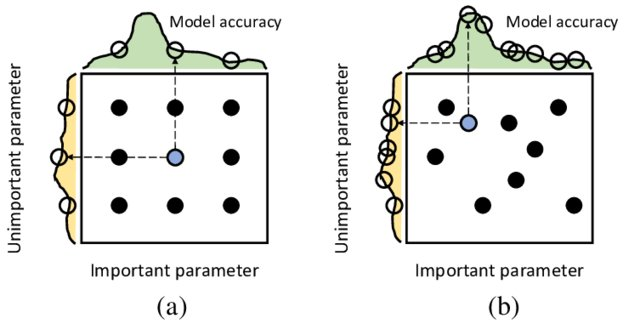

In [ ]:
# Create an SVM pipeline with SMOTE and StandardScaler and then gridsearch it using five cross-validation folds 
model = imbpipeline([
        ('sample', SMOTE()),
        ('std', StandardScaler()),
        ('clf', SVC())])

param_grid = {'clf__C': [0.1, 1, 10, 100, 1000],
              'clf__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'clf__kernel': ['rbf','poly']}
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, scoring = 'roc_auc')
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_estimator_)

{'clf__C': 100, 'clf__gamma': 1, 'clf__kernel': 'poly'}
Pipeline(steps=[('sample', SMOTE()), ('std', StandardScaler()),
                ('clf', SVC(C=100, gamma=1, kernel='poly'))])


#**Learning Curves**

Test Mean:  [       nan        nan 0.94166667 0.95833333 0.95833333]


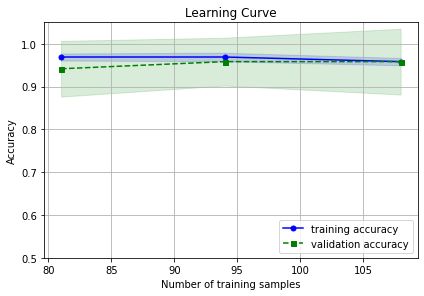

In [ ]:
model = imbpipeline([
        ('sample', SMOTE()),
        ('std', StandardScaler()),
        ('clf', SVC(C=1,gamma=0.1,kernel='rbf'))])

train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.5, 1.0, 5),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


print('Test Mean: ',test_mean)
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.05])
plt.tight_layout()
plt.title('Learning Curve')
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

In [ ]:
# Final Performance Assessment of SVM classifier
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: %.3f' % np.mean(scores))
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean accuracy: 0.942
Mean ROC AUC: 0.991


In [ ]:
# Generate a sample confusion matrix using the SVM model
model.fit(X,y)
y_test = model.predict(X_test)
print(confusion_matrix(y_test, y_pred, labels=[0,1]))

[[20  0]
 [ 1  9]]


#**Propensities**

In [ ]:
# Examine the propensities after classifying X_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
sm = SMOTE(random_state=12346)
X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)
stdsc = StandardScaler()  
X_train_SMOTE_std = stdsc.fit_transform(X_train_SMOTE)   
X_test_std = stdsc.transform(X_test)
model = SVC(C=1,gamma=0.1,kernel='rbf',probability=True)
model.fit(X_train_SMOTE_std,y_train_SMOTE)
# The output of the predict_proba method below will a list of lists of the form [p(not virginica), p(virginica)]
model.predict_proba(X_test)
 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([[0.08727945, 0.91272055],
       [0.57955069, 0.42044931],
       [0.02159262, 0.97840738],
       [0.06964697, 0.93035303],
       [0.06481204, 0.93518796],
       [0.48080289, 0.51919711],
       [0.08961912, 0.91038088],
       [0.06918366, 0.93081634],
       [0.01513048, 0.98486952],
       [0.07313981, 0.92686019],
       [0.08894096, 0.91105904],
       [0.57827851, 0.42172149],
       [0.58113287, 0.41886713],
       [0.58733141, 0.41266859],
       [0.57955069, 0.42044931],
       [0.132003  , 0.867997  ],
       [0.05607474, 0.94392526],
       [0.06200491, 0.93799509],
       [0.07474418, 0.92525582],
       [0.03547545, 0.96452455],
       [0.54572628, 0.45427372],
       [0.06534095, 0.93465905],
       [0.48080289, 0.51919711],
       [0.03621183, 0.96378817],
       [0.23313391, 0.76686609],
       [0.05580547, 0.94419453],
       [0.02085452, 0.97914548],
       [0.0848771 , 0.9151229 ],
       [0.46141571, 0.53858429],
       [0.53303767, 0.46696233],
       [0.

#**Conclusion**
A classifier horse race was staged to identify the SVM classifier recommendation (expected AUC of 0.99 and expected accuracy of 0.949). Synthetic data generated to balance the dataset, and it was standardized. The SVM was grid searched to optimize hyperparameters (which are gamma = .01, rbf kernel, and C=1). Decision region analysis on the unbalanced suggests that the SVM and LightGBM classifiers may offer the best fits (the others may be slightly overfitted). Almost all the classifiers would provide similar performance though. 

The first improvement would be to **FIX THE CAMERA ALREADY!!!**, so that we can use sepal length and petal length as predictors. Beyond that, further improvements could be sought by collecting more data, by targetting hard-to-classify irises - using [borderlineSMOTE or ADASYN](https://towardsdatascience.com/class-imbalance-smote-borderline-smote-adasyn-6e36c78d804) generation of such synthetic instances, and the use of boost ensembles that target hard-to-classify instances.

